# Summarizing the raw files

The 218 inverter data files from the SunPower data set contain data of unknown length and quality. Some files have data from 2014 through 2017, while other files represent systems built recently and have less than a year's worth of data. In addition, some sites have experienced outages (either PV or DAS) and are missing data. This notebook inspects summary data for all the files.

In [33]:
from core.preprocessing import summarize_files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')
from simplekml import Kml

In [2]:
path_to_files = '/Users/bennetmeyers/Documents/CS229/Project/data_dump/'

In [3]:
%time summary = summarize_files(path_to_files, suffix='pkl')

218 files to process
CPU times: user 27.4 s, sys: 6.73 s, total: 34.2 s
Wall time: 34.8 s


In [4]:
len(summary)

327

In [5]:
summary.head()

,system key,t_start,t_end,num_vals,ac_max,ac_min,ac_avg,ac_stdev,site ID
0,001C4B0008A5_SPMS_001C4B001030,2014-01-01 00:06:50,2017-07-22 03:09:58,36683,4061.0,0.0,1261.932694,1068.083605,001C4B0008A5
1,001C4B0008A5_SPMS_001C4B001069,2014-01-01 00:06:50,2017-07-22 03:09:58,29319,4062.0,0.0,1174.069579,989.235167,001C4B0008A5
2,0022F2000C2D_SPMS_0022F2000C2D,2014-01-01 00:06:50,2017-07-22 00:48:49,62029,7061.0,0.0,2119.665415,1758.544032,0022F2000C2D
3,0022F2000C2D_SPMS_0022F2000C8C,2014-01-01 00:06:50,2017-07-22 00:48:49,61535,4064.0,0.0,1424.010693,1175.636320,0022F2000C2D
4,0022F200152D_SPMS_0022F2000CA3,2014-01-01 00:09:59,2014-08-18 17:22:30,9907,7066.0,0.0,2757.036136,2090.906490,0022F200152D


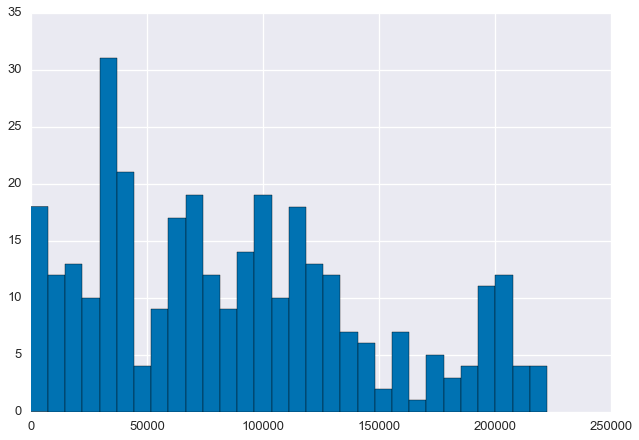

In [6]:
_ = plt.hist(summary['num_vals'], bins=30)

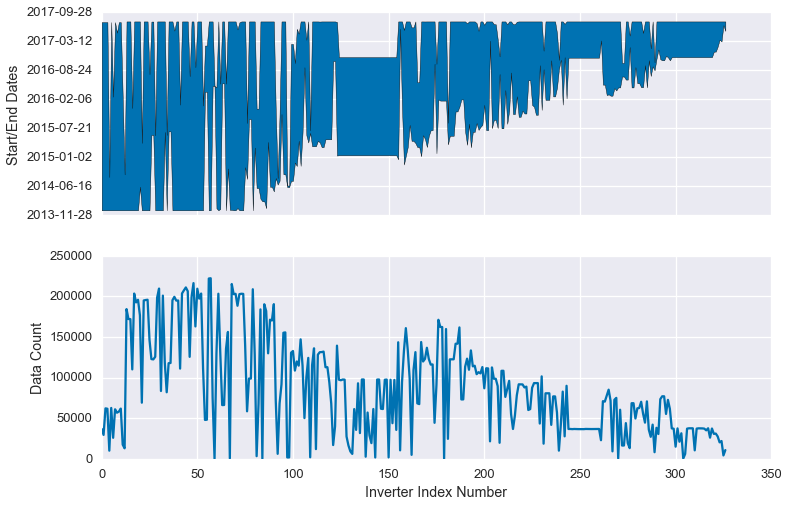

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(12,8), sharex=True)
axes[0].fill_between(summary.index, date2num(list(summary['t_start'])), date2num(list(summary['t_end'])))
xfmt = DateFormatter('%Y-%m-%d')
axes[0].yaxis.set_major_formatter(xfmt)
axes[1].plot(summary.index, summary['num_vals'])
plt.xlabel('Inverter Index Number')
axes[0].set_ylabel('Start/End Dates')
axes[1].set_ylabel('Data Count')

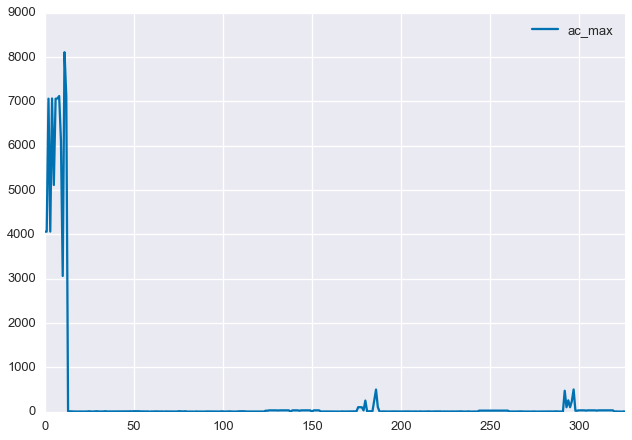

In [8]:
summary.plot(y='ac_max')

The first 10 or so files appear to have AC power in Watts, while all the rest are in kW.

In [9]:
indexer = summary['ac_max'] > 2000
summary.loc[indexer, ['ac_max']] = summary.loc[indexer, ['ac_max']] / 1000.
summary.loc[indexer, ['ac_min']] = summary.loc[indexer, ['ac_max']] / 1000.
summary.loc[indexer, ['ac_avg']] = summary.loc[indexer, ['ac_max']] / 1000.
summary.loc[indexer, ['ac_stdev']] = summary.loc[indexer, ['ac_max']] / 1000.

(0, 40)

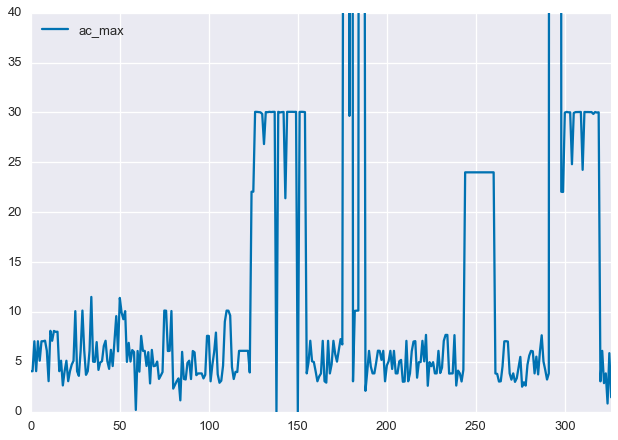

In [10]:
summary.plot(y='ac_max')
plt.ylim(0, 40)

(0, 40)

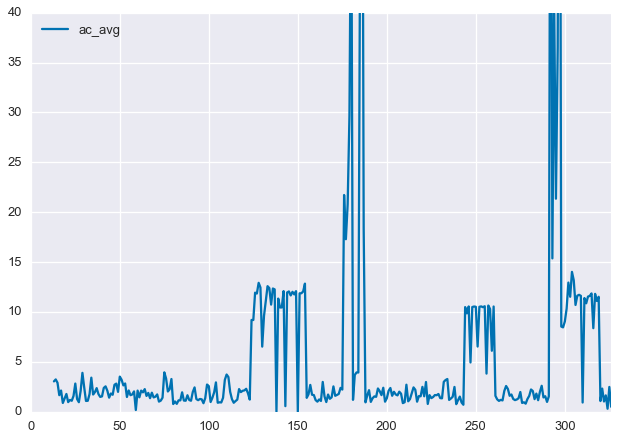

In [11]:
summary.plot(y='ac_avg')
plt.ylim(0, 40)

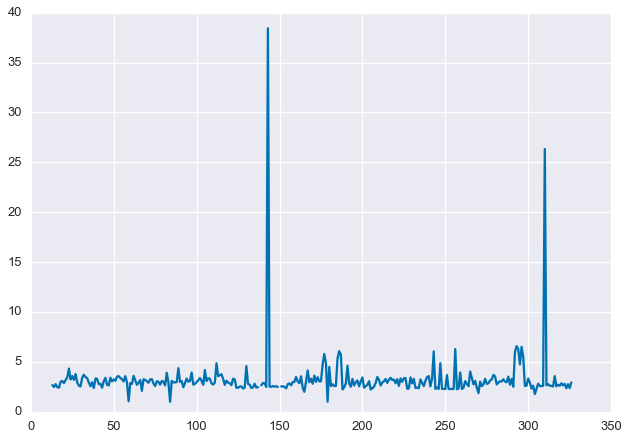

In [12]:
plt.plot(summary['ac_max'] / summary['ac_avg'])

In [13]:
selection = np.alltrue([
    summary['t_start'] >= '2015-07-15',
    summary['t_end'] >= '2017-07-15',
    summary['num_vals'] >= 75000,
    summary['ac_max'] / summary['ac_avg'] <= 10
], axis=0)

In [20]:
num_inverters = np.sum(selection)
num_sites = len(set(summary[selection]['site ID']))
print 'This selection yields {} sites and {} inverters'.format(num_sites, num_inverters)

This selection yields 33 sites and 44 inverters


In [23]:
selected_sites = set(summary[selection]['site ID'])

Load the external metadata file containing the lat/long coordinates.

In [21]:
metadata_fp = '/Users/bennetmeyers/Documents/Vader/data/metadata_files/deviceMetaData_20171108_LatLon.csv'
site_metadata = pd.read_csv(metadata_fp)

In [29]:
site_metadata.set_index('serialNumber', inplace=True)

Plot the spatial distribution

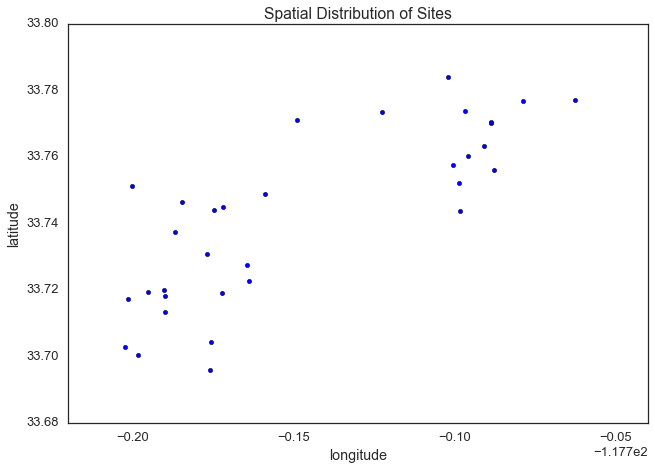

In [55]:
sns.set_style('white')
coords = site_metadata.loc[selected_sites, ['lat', 'lon']]
plt.scatter(coords['lon'], coords['lat'])
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='x')
plt.title('Spatial Distribution of Sites')
plt.ylabel('latitude')
_ = plt.xlabel('longitude')

Write a KML file mapping the locations of the selected sites.

In [41]:
my_kml = Kml()
for row in site_metadata.loc[selected_sites].iterrows():
    str1 = (row[0]+'<br/>'+'# of inverters: {}'.format(row[1]['inverters'])+
            '<br/>'+'type: '+row[1]['addressType'])
    pnt = my_kml.newpoint(description=str1, coords=[(row[1]['lon'], row[1]['lat'])])
    if row[1]['addressType'] == 'Residential':
        pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/ylw-blank.png'
    elif row[1]['addressType'] == 'Commercial':
        pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/blu-blank.png'
    else:
        pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/wht-blank.png'

In [42]:
my_kml.save("selected_sites.kml")

In [64]:
np.savetxt('selected_sites.txt', np.asarray(list(selected_sites)), fmt='%s')